In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [4]:
mice = ["mpfc14", "mpfc19", "mpfc20", "mpfc23", "mpfc24", "mpfc30"]
days = ["yd1", "yd2", "yd6"]

In [5]:
beh = []
for mi, mouse in enumerate(mice):
    behs = []
    for di, day in enumerate(days):
        df = pd.read_csv("behavior/" + mouse + "/" +mouse + "_" + day + ".csv", header=None).values
        
        n = len(df[:, 0])
        t = np.zeros(n)
        for i in range(1, n-1):
            if df[i, 0] == 1:
                t[i] = 1
            else:
                if df[i-1, 0] == 1 and df[i+1, 0] == 1:
                    t[i] = 1
        df[:, 0] = t.copy()
        
        # remove "just-in-case" lick
        count = 0
        for i in range(n):
            if df[i, 2] == 1:
                count = 0
            elif df[i, 1] == 1:
                if count < 50:
                    df[i, 1] = 0
                count = 0
            else:
                count += 1
                
        behs.append(df)
    beh.append(behs)

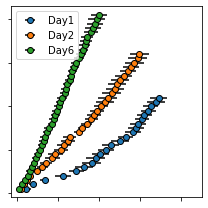

In [6]:
plt.figure(figsize=(3, 3))
for di, day in enumerate(["Day1", "Day2", "Day6"]):
    tmp = np.zeros((100, 6))
    tmp[:, :] = np.nan
    for mj, _ in enumerate(mice):
        rew = np.where(beh[mj][di][:, 2])[0]
        tmp[:len(rew), mj] = rew
    n = np.sum(np.isnan(tmp).sum(axis=1) == 0)
    xerr = np.sqrt(tmp[:n].var(axis=1) / 5)
    plt.errorbar(tmp[:n].mean(axis=1), np.arange(n)+1, xerr=xerr, fmt="o", ecolor="black", markeredgecolor="black", color="C"+str(di), label=day)
plt.legend()
plt.xticks([5000*i for i in range(5)], [1000*i for i in range(5)])
plt.xlim(plt.xlim()[0], 4.5*5000)
plt.yticks([10*i for i in range(5)])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2c.png")

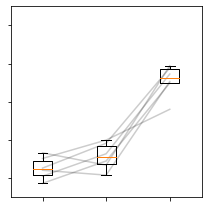

In [7]:
tmp = np.zeros((6, 3))
plt.figure(figsize=(3, 3))
for mi, _ in enumerate(mice):
    for di, _ in enumerate(days):
        tmp[mi, di] = beh[mi][di][:, 2].sum() / beh[mi][di][:, 1].sum()
plt.plot(np.arange(3)+1, tmp.T, color="black", alpha=0.2)
plt.boxplot(tmp, sym="")
plt.ylim(0.1, 1.1)
plt.xticks([1,2,3], ["Day 1", "Day 2", "Day 6"])
plt.tick_params(labelleft=False, labelbottom=False)
plt.tight_layout()
plt.savefig("paper/fig2/fig2d.png")

In [9]:
df = pd.DataFrame({
    "rate": np.hstack((tmp[:, 0], tmp[:, 1], tmp[:, 2])),
    "day": np.repeat(["Day1", "Day2", "Day6"], 6)
})
tukey = pairwise_tukeyhsd(endog=df['rate'],
                          groups=df['day'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
  Day1   Day2   0.0619 0.3174 -0.045 0.1689  False
  Day1   Day6   0.4608  0.001 0.3538 0.5678   True
  Day2   Day6   0.3989  0.001 0.2919 0.5058   True
--------------------------------------------------
